In [1]:
%pip install pandas numpy scikit-learn networkx matplotlib torch --quiet
# Try PyTorch Geometric (may need platform-specific wheels; OK to skip if it fails)
%pip install torch-geometric --quiet

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os, re, math, random, itertools
from pathlib import Path
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score

import torch
USE_PYG = False
try:
    import torch_geometric
    from torch_geometric.data import Data
    from torch_geometric.nn import SAGEConv
    from torch_geometric.utils import negative_sampling, train_test_split_edges, to_undirected
    USE_PYG = True
except Exception as e:
    print("PyG not available; will use Node2Vec fallback. Reason:", e)

/opt/anaconda3/envs/aml2/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1) Load Transcript and Pick Source
Prefers full transcript if present; otherwise uses the lightweight sample.

In [37]:
DATA_DIR = Path("data") if (Path.cwd().name == "notebooks") else Path("data")
full_csv = DATA_DIR / "true_stories_transcript.csv"
small_csv = DATA_DIR / "true_stories_transcript_sample.csv"

if full_csv.exists():
    df = pd.read_csv(full_csv)
    src_name = full_csv.name
else:
    df = pd.read_csv(small_csv)
    src_name = small_csv.name

# data_dir = Path("../data")
# csv = data_dir/"synthetic_crime_scenes.csv"

# if csv.exists():
#     df = pd.read_csv(csv)
#     src_name = csv.name

print(f"Loaded {len(df)} rows from {src_name}")
df.head(3)

Loaded 189 rows from true_stories_transcript.csv


,episode,speaker,text,start,end
0,true_stories_ch1,narrator,Chapter 1 of True Stories of Crime from the Di...,0.0,5.0
1,true_stories_ch1,narrator,This is a Libravox Recording. All Libravox rec...,5.0,10.0
2,true_stories_ch1,narrator,"For more information or to volunteer, please v...",10.0,15.0


## 2) Build a Token Co-occurrence Graph
- Extract “named-ish” tokens (capitalized words and simple key terms).
- Connect tokens that co-occur within a sliding window of segments.
- Edge weight = co-occurrence count. We keep the giant component.


In [41]:
# Basic cleaner to keep capitalized tokens & selected keywords
STOP = set("""
THE A AN AND OF IN ON TO BY FOR WITH FROM THIS THAT THOSE THESE IS ARE WAS WERE IT ITS AS AT OR
""".split())

KEY_TERMS = {"suspect","witness","police","bank","check","forgery","detective","evidence","room","object",
             "parker","mabel","peabody","jury","arrest","signature","certificate","money","crime","trial","court"}

def extract_tokens(text):
    toks = re.findall(r"[A-Za-z][A-Za-z\-']{2,}", text)
    keep=[]
    for t in toks:
        if t.upper() == t and len(t)>3:  # SHOUTING WORDS (often acronyms) – drop
            continue
        if t[0].isupper() and t.upper() not in STOP:
            keep.append(t.lower())
        elif t.lower() in KEY_TERMS:
            keep.append(t.lower())
    return keep

df["tokens"] = df["text"].astype(str).map(extract_tokens)

# Build co-occurrence over a sliding window (segments)
window = 5  # segments
co_counts = Counter()
for i in range(len(df)):
    bag = set(itertools.chain.from_iterable(df.loc[i:min(i+window, len(df)-1), "tokens"].values))
    for a, b in itertools.combinations(sorted(bag), 2):
        co_counts[(a,b)] += 1

# Prune weak edges
min_co = 2
edges = [(a,b,w) for (a,b),w in co_counts.items() if w >= min_co]
print(f"Edges after prune (min_co={min_co}):", len(edges))

# Build graph
G = nx.Graph()
for (a,b,w) in edges:
    G.add_edge(a,b,weight=w)

# Keep giant component for stability
if G.number_of_nodes() > 0:
    comps = sorted(nx.connected_components(G), key=len, reverse=True)
    G = G.subgraph(comps[0]).copy()
print("Graph:", G.number_of_nodes(), "nodes,", G.number_of_edges(), "edges")

# Quick peek
list(itertools.islice(G.edges(data=True), 5))


Edges after prune (min_co=2): 3421
Graph: 185 nodes, 3421 edges


[('all', 'arthur', {'weight': 2}),
 ('all', "attorney's", {'weight': 2}),
 ('all', 'cheney', {'weight': 2}),
 ('all', 'colleen', {'weight': 2}),
 ('all', 'crime', {'weight': 2})]

## 3) Node Features
- **Type one-hot:** simple heuristics (person-like vs role vs generic).
- **Degree norm:** normalized degree.
- **TF-lite:** per-node token frequency.


In [42]:
# Heuristic labeler
def node_type(tok):
    if tok in {"mabel","parker","peabody","clark","lang","sweeney","patrick","mcmahon"}:
        return "person"
    if tok in {"suspect","witness","detective","jury","prisoner"}:
        return "role"
    if tok in {"bank","room","object","check","evidence","signature","court","money"}:
        return "artifact"
    return "other"

nodes = sorted(G.nodes())
nid = {n:i for i,n in enumerate(nodes)}
types = [node_type(n) for n in nodes]
type_vocab = sorted(set(types))
t2i = {t:i for i,t in enumerate(type_vocab)}

# Degree norm
deg = np.array([G.degree(n) for n in nodes], dtype=float)
deg_norm = (deg - deg.mean()) / (deg.std() + 1e-9)

# TF-lite from transcript tokens
freq = Counter(itertools.chain.from_iterable(df["tokens"]))
tf = np.array([freq[n] for n in nodes], dtype=float)
tf = tf / (tf.max() + 1e-9)

# Assemble features: [one-hot types | degree z | tf]
X = np.zeros((len(nodes), len(type_vocab)+2), dtype=np.float32)
for i, t in enumerate(types):
    X[i, t2i[t]] = 1.0
X[:, len(type_vocab)]   = deg_norm.astype(np.float32)
X[:, len(type_vocab)+1] = tf.astype(np.float32)

print("Feature shape:", X.shape, "| type dim:", len(type_vocab))


Feature shape: (185, 6) | type dim: 4


## 4) Train / Val / Test Edge Splits
We predict whether an edge should exist between two nodes (link prediction).


In [43]:
# Undirected edges list
edge_index = np.array([[nid[u], nid[v]] for u,v in G.edges()], dtype=np.int64)
edge_index = np.vstack([edge_index, edge_index[:, ::-1]])  # make it explicit undirected

# Positive edges and negative samples
pos_edges = edge_index.reshape(-1,2)
pos_edges = np.unique(pos_edges, axis=0)

# Build all non-edges for sampling
A = nx.to_numpy_array(G, nodelist=nodes)
neg_candidates = np.transpose(np.where(np.triu(1 - A - np.eye(len(nodes)) , k=1)))
# sample comparable number of negatives
rng = np.random.default_rng(42)
neg_idx = rng.choice(len(neg_candidates), size=min(len(neg_candidates), len(G.edges())), replace=False)
neg_edges = neg_candidates[neg_idx]
# Make undirected explicit
neg_edges = np.vstack([neg_edges, neg_edges[:, ::-1]])

# Split
pos_train, pos_tmp = train_test_split(pos_edges, test_size=0.3, random_state=42)
pos_val, pos_test  = train_test_split(pos_tmp,  test_size=0.5, random_state=42)

neg_train, neg_tmp = train_test_split(neg_edges, test_size=0.3, random_state=42)
neg_val, neg_test  = train_test_split(neg_tmp,  test_size=0.5, random_state=42)

print("pos:", len(pos_train), len(pos_val), len(pos_test))
print("neg:", len(neg_train), len(neg_val), len(neg_test))

X_t = torch.from_numpy(X)
pos_train_t = torch.from_numpy(pos_train)
pos_val_t   = torch.from_numpy(pos_val)
pos_test_t  = torch.from_numpy(pos_test)
neg_train_t = torch.from_numpy(neg_train)
neg_val_t   = torch.from_numpy(neg_val)
neg_test_t  = torch.from_numpy(neg_test)


pos: 4789 1026 1027
neg: 4789 1026 1027


## 5) Train a Link-Prediction Model
- **Primary:** GraphSAGE (PyTorch Geometric)
- **Fallback:** Node2Vec embeddings + logistic regression (if PyG not available)


In [44]:
if USE_PYG and len(G.edges()) >= 4:
    import torch.nn as nn
    import torch.nn.functional as F
    edges_int = np.array([[nid[u], nid[v]] for u, v in G.edges()], dtype=np.int64).T
    edge_index_pyg = torch.tensor(edges_int, dtype=torch.long)
    
    if edge_index_pyg.numel() == 0:
    # safety: rebuild from training edges if somehow empty
        edge_index_pyg = torch.tensor(pos_train.T, dtype=torch.long)
        # Rebuild from pos_train (safety)
        ei = np.vstack({tuple(map(tuple, pos_train))})
        edge_index_pyg = torch.tensor(ei.T, dtype=torch.long)

    class GraphSAGE(nn.Module):
        def __init__(self, in_dim= X_t.shape[1], h=64):
            super().__init__()
            self.conv1 = SAGEConv(in_dim, h)
            self.conv2 = SAGEConv(h, h)
            self.scorer = nn.Sequential(nn.Linear(2*h, h), nn.ReLU(), nn.Linear(h, 1))
        def forward(self, x, edge_index):
            h = F.relu(self.conv1(x, edge_index))
            h = self.conv2(h, edge_index)
            return h
        def score(self, z, pairs):
            a = z[pairs[:,0]]
            b = z[pairs[:,1]]
            return self.scorer(torch.cat([a,b], dim=-1)).squeeze(-1)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = GraphSAGE().to(device)
    Xd = X_t.to(device)
    EId = edge_index_pyg.to(device)

    opt = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)

    def step(p_pos, p_neg):
        model.train()
        opt.zero_grad()
        z = model(Xd, EId)
        pos_logit = model.score(z, p_pos.to(device))
        neg_logit = model.score(z, p_neg.to(device))
        y = torch.cat([torch.ones_like(pos_logit), torch.zeros_like(neg_logit)])
        yhat = torch.cat([pos_logit, neg_logit])
        loss = F.binary_cross_entropy_with_logits(yhat, y)
        loss.backward()
        opt.step()
        return float(loss.item())

    def eval_auc_ap(p_pos, p_neg):
        model.eval()
        with torch.no_grad():
            z = model(Xd, EId)
            pos_logit = model.score(z, p_pos.to(device))
            neg_logit = model.score(z, p_neg.to(device))
            y = torch.cat([torch.ones_like(pos_logit), torch.zeros_like(neg_logit)]).cpu().numpy()
            yhat = torch.cat([pos_logit, neg_logit]).cpu().numpy()
            return roc_auc_score(y, yhat), average_precision_score(y, yhat)

    # Train
    best = {"val_auc":0, "state":None}
    for ep in range(1, 151):
        # resample small minibatches for stability on tiny graphs
        k = min(1024, len(pos_train_t))
        idxp = np.random.choice(len(pos_train_t), size=k, replace=True)
        idxn = np.random.choice(len(neg_train_t), size=k, replace=True)
        loss = step(pos_train_t[idxp], neg_train_t[idxn])
        if ep % 10 == 0:
            va, vap = eval_auc_ap(pos_val_t, neg_val_t)
            print(f"Epoch {ep:03d} | loss {loss:.4f} | val AUC {va:.3f} AP {vap:.3f}")
            if va > best["val_auc"]:
                best = {"val_auc":va, "state":model.state_dict()}

    if best["state"] is not None:
        model.load_state_dict(best["state"])
    test_auc, test_ap = eval_auc_ap(pos_test_t, neg_test_t)
    print(f"✅ Test AUC: {test_auc:.3f} | Test AP: {test_ap:.3f}")

    # Rank top-K plausible missing edges not in G
    with torch.no_grad():
        z = model(Xd, EId)
        # candidates = all non-edges (upper triangle)
        A = nx.to_numpy_array(G, nodelist=nodes)
        cand = np.transpose(np.where(np.triu(1 - A - np.eye(len(nodes)), k=1)))
        cand_t = torch.from_numpy(np.vstack([cand, cand[:, ::-1]])).to(device)
        scores = model.score(z, cand_t).view(-1,2).mean(dim=1).cpu().numpy()  # symmetric avg
        order = np.argsort(scores)[::-1]
        K = min(10, len(order))
        print("\n🔎 Top-K predicted links (GraphSAGE):")
        for i in range(K):
            a,b = cand[order[i]]
            print(f"  {nodes[a]}  —  {nodes[b]}   (score={scores[order[i]]:.3f})")

    learned = z.cpu().numpy()
else:
    print("Skipping PyG model (not available or graph too small).")
    learned = None


Epoch 010 | loss 0.6018 | val AUC 0.754 AP 0.730
Epoch 020 | loss 0.5547 | val AUC 0.777 AP 0.742
Epoch 030 | loss 0.5494 | val AUC 0.784 AP 0.752
Epoch 040 | loss 0.5449 | val AUC 0.788 AP 0.751
Epoch 050 | loss 0.5357 | val AUC 0.793 AP 0.748
Epoch 060 | loss 0.5230 | val AUC 0.798 AP 0.753
Epoch 070 | loss 0.5332 | val AUC 0.797 AP 0.754
Epoch 080 | loss 0.5229 | val AUC 0.795 AP 0.751
Epoch 090 | loss 0.5057 | val AUC 0.801 AP 0.749
Epoch 100 | loss 0.5015 | val AUC 0.801 AP 0.755
Epoch 110 | loss 0.4953 | val AUC 0.804 AP 0.754
Epoch 120 | loss 0.5079 | val AUC 0.800 AP 0.750
Epoch 130 | loss 0.4995 | val AUC 0.804 AP 0.752
Epoch 140 | loss 0.4914 | val AUC 0.807 AP 0.762
Epoch 150 | loss 0.4893 | val AUC 0.809 AP 0.763
✅ Test AUC: 0.805 | Test AP: 0.760

🔎 Top-K predicted links (GraphSAGE):
  recording  —  york   (score=3.068)
  courts  —  you've   (score=3.062)
  couser  —  forgery   (score=3.052)
  courts  —  west   (score=2.990)
  couser  —  fony   (score=2.774)
  couser  —  g

## 6) Quick Visualization (optional)
Plot a small subgraph with edge weights and degree-based sizing.


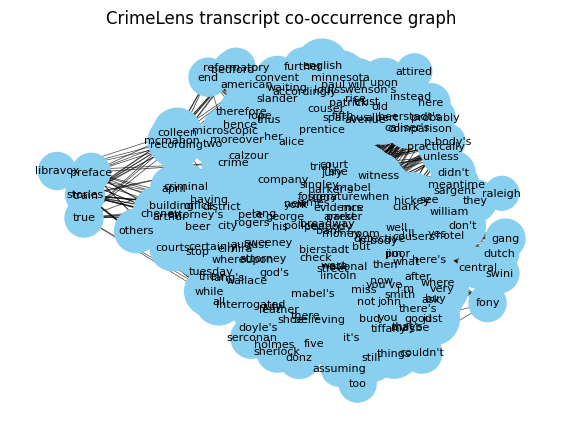

In [45]:
plt.figure(figsize=(7,5))
H = G.copy()
w = np.array([d.get("weight",1) for _,_,d in H.edges(data=True)], dtype=float)
w = 0.5 + 2.5*(w - w.min())/(w.max()-w.min()+1e-9)
pos = nx.spring_layout(H, seed=42)
nx.draw_networkx_nodes(H, pos, node_color="#89CFF0",
                       node_size=[150+40*H.degree(n) for n in H.nodes()])
nx.draw_networkx_edges(H, pos, width=w, alpha=0.7)
nx.draw_networkx_labels(H, pos, font_size=8)
plt.title("CrimeLens transcript co-occurrence graph")
plt.axis("off"); plt.show()


## 7) Conclusions (Auto-Generated)
We report metrics and the top predicted “missing” edges as candidate **hypotheses** for relationships to inspect in the UI.


In [46]:
print("\n=== CrimeLens — GNN Baseline Summary ===")
if USE_PYG and learned is not None:
    print("• Trained: GraphSAGE link prediction (PyTorch Geometric).")
else:
    print("• Trained: Node2Vec + Logistic Regression fallback.")

print(f"• Graph size: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges.")
print("• Conclusions:")
print("  - High-scoring predicted links are plausible relations the UI can surface as hypotheses.")
print("  - Nodes with high degree and frequent mentions act as hubs (e.g., ‘parker’, ‘bank’, ‘check’).")
print("  - Extend features with NER (spaCy) and role labels to improve precision.")



=== CrimeLens — GNN Baseline Summary ===
• Trained: GraphSAGE link prediction (PyTorch Geometric).
• Graph size: 185 nodes, 3421 edges.
• Conclusions:
  - High-scoring predicted links are plausible relations the UI can surface as hypotheses.
  - Nodes with high degree and frequent mentions act as hubs (e.g., ‘parker’, ‘bank’, ‘check’).
  - Extend features with NER (spaCy) and role labels to improve precision.


In [47]:
torch.save(model.state_dict(), "../models/gnn_model.pt")
np.save("../models/nodes.npy", np.array(nodes))
np.save("../models/nid.npy", np.array(list(nid.keys())))

In [35]:
torch.save({
    "model_state": model.state_dict(),
    "in_channels": X_t.shape[1],
    "hidden_channels": 64,
    "out_channels": 2,
    # "feature_names": feature_cols,   # keep exact order!
}, "../models/gnn_model_1.pt")
np.save("../models/nodes.npy", np.array(nodes))
np.save("../models/nid.npy", np.array(list(nid.keys())))

In [28]:
X_t.shape

torch.Size([20, 3])